In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from tqdm import tqdm

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
all_pairs = pd.read_csv('all_pairs.csv')
all_pairs = [eval(x) for x in all_pairs.Target]
features = np.load('format_features.npy')[:,:-1]
features_with_class = np.load('format_features.npy')
edges = pd.read_csv('edges.csv')

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

In [6]:
edges['is_connected'] = 1

In [7]:
false_target = np.random.randint(low=0, high=len(features), size=len(edges))
false_source = np.random.randint(low=0, high=len(features), size=len(edges))
false_edges = edges.append(pd.DataFrame({'Target':false_target, 'Source':false_source})).drop_duplicates()[len(edges):]
false_edges['is_connected'] = 0
false_edges = false_edges[false_edges['Target']!=false_edges['Source']]

In [8]:
data = edges.append(false_edges)

In [9]:
data = data.sample(frac = 1) 

In [10]:
data_X = data[['Target', 'Source']]
data_y = data['is_connected']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25, random_state=42)

In [12]:
def create_batch(nodes):
    first_nodes = nodes.Target
    second_nodes = nodes.Source
    
    return(torch.tensor([features[first_nodes],features[second_nodes]]).float())

In [13]:
class Net(torch.nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()
        self.convert = nn.Linear(num_features*2,1000)
        self.lin1 = nn.Linear(1000,500)
        self.lin2 = nn.Linear(500,100)
        self.lin3 = nn.Linear(100,1)
#         self.lin4 = nn.Linear(50,1)
        self.sigm = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)
    def forward(self, first_node, second_node):
        
        x = torch.cat((first_node,second_node), 1)
        x = self.convert(x)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)
#         x = F.relu(x)
#         x = self.lin4(x)
        x = self.dropout(x)
        x = self.sigm(x)
        return(x.squeeze(1))
    def computeLoss(self, first_numbers, second_numbers, answers):
        loss = nn.BCELoss()
        preds = self.forward(first_numbers, second_numbers)
        output = loss(preds, answers)
        return(output)

In [14]:
model = Net(1433)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

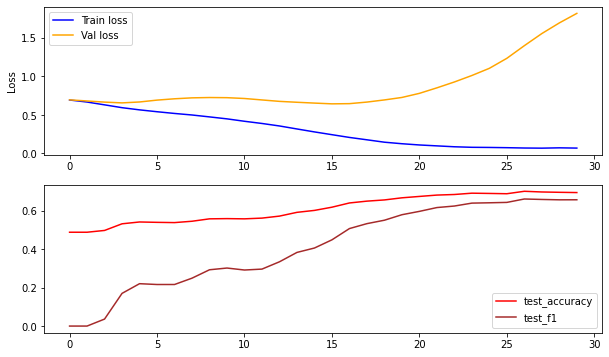

In [17]:
num_epochs = 30
batch_size = 5000
train_losses = []
val_losses = []
accs = []
f1s = []
for i in range(num_epochs):
    model.train(False)
    test_first = torch.tensor(features[X_test.Target.tolist()]).float()
    test_second = torch.tensor(features[X_test.Source.tolist()]).float()
    test_ans = torch.tensor(y_test.tolist()).float()
    val_loss = model.computeLoss(test_first, test_second, test_ans)
    val_losses.append(val_loss)
    train_loss= 0
    val_loss = 0
    model.train(True)
    batches_num = len(X_train)//batch_size
    optimizer.zero_grad()
    for j in range(batches_num):
        data = X_train[j*batch_size:(j+1)*batch_size]
        first_nodes = torch.tensor(features[data.Target.tolist()]).float()
        second_nodes = torch.tensor(features[data.Source.tolist()]).float()
        answers = torch.tensor(y_train[j*batch_size:(j+1)*batch_size].tolist()).float()
        loss_value = model.computeLoss(first_nodes, second_nodes, answers)
        loss_value.backward()
        train_loss += loss_value.item()
    optimizer.step()
    train_loss/= batches_num
    train_losses.append(train_loss)
    clear_output()
    plt.figure(figsize = (10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label = 'Train loss', color = 'blue')
    plt.plot(val_losses, label = 'Val loss', color = 'orange')
    plt.ylabel('Loss')
    preds = (model.forward(test_first, test_second)>=0.9).int()
#     preds = model.forward(test_first, test_second)
    acc = accuracy_score(preds,y_test.tolist())
    f1 = f1_score(preds,y_test.tolist())
    accs.append(acc)
    f1s.append(f1)
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(accs, label = 'test_accuracy', color = 'red')
    plt.plot(f1s, label = 'test_f1', color = 'brown')
    plt.legend()
    plt.show()

In [18]:
max(accs)

0.6998294485503127

In [ ]:
#ниже не работает адекватно пока что

In [46]:
f = torch.tensor([features[6] for x in features]).float()

In [47]:
s = torch.tensor(features).float()

In [66]:
order = np.random.permutation(len(features))

In [67]:
order

array([1869, 2372, 1436, ..., 1100,  166,  404])

In [68]:
def find_first_one(arr):
    for i in range(len(arr)):
        if arr[i]==1:
            return(i)
    return(len(arr))

In [69]:
graph_features = [features[order[0]]]
order = order[1:]
edges = []

In [70]:
first_possible=0

In [71]:
for i in tqdm(order):
    now_feature = features[order[0]]
    f = torch.tensor([now_feature for x in graph_features]).float()
    pred = (model.forward(f, torch.tensor(graph_features).float())>0.99).int()
#     pred[:first_possible] = 0
    new_edges = np.array([[len(graph_features), x] for x in range(len(pred)) if pred[x]>0.5])
    if len(new_edges)!=0:
        new_edges2 = new_edges[:, [1, 0]]
        edges.extend(np.concatenate([new_edges, new_edges2]).tolist())
    graph_features.append(now_feature)
    order = order[1:]
    
    print(len(edges))

  1%|          | 19/2707 [00:00<00:15, 178.24it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
2
2


  1%|▏         | 37/2707 [00:00<00:24, 110.21it/s]

2
2
2
2
2
2
2
2
2
2
2
2
2
2


  2%|▏         | 51/2707 [00:00<00:36, 73.08it/s] 

2
2
2
2
4
40
46
48
50
52
54


  2%|▏         | 58/2707 [00:00<00:41, 63.07it/s]

56
70
70
72
72
74
74
76
76
90


  3%|▎         | 70/2707 [00:01<00:55, 47.27it/s]

90
92
92
92
92
92
92
92


  3%|▎         | 75/2707 [00:01<01:03, 41.24it/s]

92
100
100
102
102
102
108
110


  3%|▎         | 85/2707 [00:01<01:11, 36.91it/s]

110
110
112
112
114
116
116


  3%|▎         | 93/2707 [00:01<01:18, 33.12it/s]

116
136
136
192
192
194
204


  4%|▎         | 97/2707 [00:01<01:24, 30.79it/s]

210
222
226
230
230
238


  4%|▍         | 104/2707 [00:02<01:37, 26.69it/s]

242
242
246
248
252
260


  4%|▍         | 110/2707 [00:02<01:46, 24.44it/s]

262
262
266
270
276


  4%|▍         | 116/2707 [00:02<01:50, 23.44it/s]

286
288
294
296
308
314


  4%|▍         | 119/2707 [00:02<01:50, 23.41it/s]

320
328
328
330
340


  5%|▍         | 125/2707 [00:03<01:57, 21.92it/s]

340
344
360
368


  5%|▍         | 128/2707 [00:03<02:01, 21.28it/s]

374
374
386
388
398


  5%|▍         | 134/2707 [00:03<02:01, 21.23it/s]

398
406
410
412
422


  5%|▌         | 140/2707 [00:03<02:04, 20.62it/s]

424
454
458
460
462


  5%|▌         | 143/2707 [00:04<02:07, 20.15it/s]

472
476
476
476
476


  5%|▌         | 148/2707 [00:04<02:11, 19.42it/s]

476
484
484
492


  6%|▌         | 152/2707 [00:04<02:22, 17.94it/s]

500
500
508
516


  6%|▌         | 156/2707 [00:04<02:29, 17.06it/s]

544
546
610
618


  6%|▌         | 160/2707 [00:05<02:32, 16.72it/s]

620
620
620
620


  6%|▌         | 164/2707 [00:05<02:38, 16.01it/s]

638
640
652
660


  6%|▌         | 168/2707 [00:05<02:43, 15.55it/s]

692
692
702
716


  6%|▋         | 172/2707 [00:05<02:49, 14.93it/s]

720
722
724


  7%|▋         | 176/2707 [00:06<02:45, 15.34it/s]

734
788
854
854


  7%|▋         | 180/2707 [00:06<02:42, 15.53it/s]

890
892
994
994


  7%|▋         | 184/2707 [00:06<02:47, 15.10it/s]

996
1002
1006
1008


  7%|▋         | 188/2707 [00:06<02:49, 14.84it/s]

1012
1014
1016
1018


  7%|▋         | 192/2707 [00:07<02:50, 14.75it/s]

1028
1032
1042
1062


  7%|▋         | 194/2707 [00:07<02:57, 14.20it/s]

1080
1080
1104


  7%|▋         | 198/2707 [00:07<03:01, 13.85it/s]

1132
1138
1138


  7%|▋         | 202/2707 [00:07<03:08, 13.31it/s]

1140
1148
1156
1158


  8%|▊         | 204/2707 [00:08<03:11, 13.05it/s]

1162
1164
1166


  8%|▊         | 208/2707 [00:08<03:20, 12.49it/s]

1166
1200
1218


  8%|▊         | 210/2707 [00:08<03:22, 12.35it/s]

1224
1228
1242


  8%|▊         | 214/2707 [00:08<03:22, 12.32it/s]

1242
1256
1260


  8%|▊         | 216/2707 [00:09<03:20, 12.40it/s]

1268
1272
1274


  8%|▊         | 220/2707 [00:09<03:25, 12.12it/s]

1280
1280
1318


  8%|▊         | 222/2707 [00:09<03:24, 12.17it/s]

1344
1350
1354


  8%|▊         | 226/2707 [00:09<03:26, 12.03it/s]

1358
1388
1416


  8%|▊         | 228/2707 [00:10<03:30, 11.78it/s]

1418
1442
1448


  9%|▊         | 232/2707 [00:10<03:40, 11.23it/s]

1450
1472
1474


  9%|▊         | 234/2707 [00:10<03:42, 11.12it/s]

1484
1494
1500


  9%|▉         | 238/2707 [00:10<03:38, 11.28it/s]

1512
1528
1588


  9%|▉         | 240/2707 [00:11<03:40, 11.18it/s]

1588
1588
1606


  9%|▉         | 244/2707 [00:11<03:42, 11.07it/s]

1614
1614
1620


  9%|▉         | 246/2707 [00:11<03:42, 11.07it/s]

1628
1628
1726


  9%|▉         | 250/2707 [00:12<03:42, 11.06it/s]

1934
1934
1942


  9%|▉         | 252/2707 [00:12<03:43, 10.98it/s]

2038
2058
2070


  9%|▉         | 256/2707 [00:12<03:48, 10.74it/s]

2086
2090
2100


 10%|▉         | 258/2707 [00:12<03:49, 10.69it/s]

2100
2106
2108


 10%|▉         | 262/2707 [00:13<03:48, 10.69it/s]

2110
2112
2114


 10%|▉         | 264/2707 [00:13<03:50, 10.60it/s]

2174
2174
2184


 10%|▉         | 268/2707 [00:13<03:53, 10.46it/s]

2186
2186
2194


 10%|▉         | 270/2707 [00:13<03:53, 10.44it/s]

2202
2220
2220


 10%|█         | 274/2707 [00:14<03:56, 10.27it/s]

2228
2248
2250


 10%|█         | 276/2707 [00:14<03:59, 10.16it/s]

2254
2266
2270


 10%|█         | 280/2707 [00:14<03:59, 10.12it/s]

2278
2280
2280


 10%|█         | 283/2707 [00:15<04:07,  9.79it/s]

2294
2298
2320


 11%|█         | 285/2707 [00:15<04:07,  9.78it/s]

2326
2340


 11%|█         | 287/2707 [00:15<04:12,  9.58it/s]

2352
2352


 11%|█         | 289/2707 [00:15<04:15,  9.47it/s]

2352
2386


 11%|█         | 291/2707 [00:16<04:13,  9.53it/s]

2404
2416


 11%|█         | 293/2707 [00:16<04:11,  9.61it/s]

2432
2524


 11%|█         | 295/2707 [00:16<04:15,  9.43it/s]

2526
2574


 11%|█         | 297/2707 [00:16<04:16,  9.38it/s]

2574
2582


 11%|█         | 299/2707 [00:17<04:27,  9.01it/s]

2612
2616


 11%|█         | 301/2707 [00:17<04:42,  8.51it/s]

2654
2664


 11%|█         | 303/2707 [00:17<04:34,  8.76it/s]

2678
2688


 11%|█▏        | 305/2707 [00:17<04:29,  8.91it/s]

2690
2692


 11%|█▏        | 307/2707 [00:17<04:29,  8.89it/s]

2702
2746


 11%|█▏        | 309/2707 [00:18<04:37,  8.63it/s]

2754
2776


 11%|█▏        | 311/2707 [00:18<04:35,  8.71it/s]

2778
2842


 12%|█▏        | 313/2707 [00:18<04:35,  8.68it/s]

2848
2858


 12%|█▏        | 315/2707 [00:18<04:34,  8.72it/s]

2882
2932


 12%|█▏        | 317/2707 [00:19<04:34,  8.71it/s]

2934
2938


 12%|█▏        | 319/2707 [00:19<04:51,  8.18it/s]

2940
2942


 12%|█▏        | 321/2707 [00:19<05:05,  7.80it/s]

2944
2978


 12%|█▏        | 323/2707 [00:19<05:10,  7.67it/s]

2980
2990


 12%|█▏        | 325/2707 [00:20<05:19,  7.45it/s]

3010
3174


 12%|█▏        | 327/2707 [00:20<05:25,  7.31it/s]

3186
3190


 12%|█▏        | 329/2707 [00:20<05:29,  7.22it/s]

3194
3200


 12%|█▏        | 331/2707 [00:20<05:25,  7.29it/s]

3208
3216


 12%|█▏        | 333/2707 [00:21<05:39,  7.00it/s]

3218
3222


 12%|█▏        | 335/2707 [00:21<05:38,  7.01it/s]

3238
3240


 12%|█▏        | 337/2707 [00:21<05:14,  7.55it/s]

3242
3244


 13%|█▎        | 339/2707 [00:22<05:00,  7.87it/s]

3252
3258


 13%|█▎        | 341/2707 [00:22<04:57,  7.94it/s]

3270
3324


 13%|█▎        | 343/2707 [00:22<04:54,  8.04it/s]

3330
3350


 13%|█▎        | 345/2707 [00:22<05:28,  7.18it/s]

3558
3560


 13%|█▎        | 347/2707 [00:23<05:06,  7.69it/s]

3562
3568


 13%|█▎        | 349/2707 [00:23<05:11,  7.58it/s]

3574
3578


 13%|█▎        | 351/2707 [00:23<05:34,  7.05it/s]

3586
3600


 13%|█▎        | 353/2707 [00:24<06:06,  6.42it/s]

3600
3654


 13%|█▎        | 355/2707 [00:24<06:03,  6.47it/s]

3654
3666


 13%|█▎        | 357/2707 [00:24<05:42,  6.86it/s]

3724
3728


 13%|█▎        | 359/2707 [00:24<05:49,  6.72it/s]

3736
3738


 13%|█▎        | 361/2707 [00:25<05:42,  6.86it/s]

3762
3762


 13%|█▎        | 363/2707 [00:25<05:51,  6.67it/s]

3838
3866


 13%|█▎        | 365/2707 [00:25<05:56,  6.58it/s]

3876
3934


 14%|█▎        | 367/2707 [00:26<05:59,  6.50it/s]

4108
4108


 14%|█▎        | 369/2707 [00:26<05:58,  6.53it/s]

4120
4124


 14%|█▎        | 371/2707 [00:26<05:51,  6.64it/s]

4134
4166


 14%|█▍        | 373/2707 [00:27<05:53,  6.61it/s]

4170
4174


 14%|█▍        | 375/2707 [00:27<05:44,  6.77it/s]

4182
4182


 14%|█▍        | 377/2707 [00:27<05:41,  6.82it/s]

4194
4200


 14%|█▍        | 379/2707 [00:27<05:40,  6.84it/s]

4210
4214


 14%|█▍        | 381/2707 [00:28<05:26,  7.12it/s]

4252
4252


 14%|█▍        | 383/2707 [00:28<05:45,  6.72it/s]

4268
4282


 14%|█▍        | 385/2707 [00:28<05:32,  6.98it/s]

4320
4322


 14%|█▍        | 387/2707 [00:29<05:39,  6.84it/s]

4324
4330


 14%|█▍        | 389/2707 [00:29<05:36,  6.88it/s]

4332
4336


 14%|█▍        | 391/2707 [00:29<05:41,  6.78it/s]

4358
4376


 15%|█▍        | 393/2707 [00:29<05:48,  6.64it/s]

4380
4392


 15%|█▍        | 395/2707 [00:30<05:42,  6.75it/s]

4398
4412


 15%|█▍        | 397/2707 [00:30<05:39,  6.81it/s]

4422
4426


 15%|█▍        | 399/2707 [00:30<05:39,  6.80it/s]

4432
4432


 15%|█▍        | 401/2707 [00:31<05:40,  6.77it/s]

4470
4470


 15%|█▍        | 403/2707 [00:31<05:46,  6.65it/s]

4488
4494


 15%|█▍        | 405/2707 [00:31<05:49,  6.59it/s]

4514
4518


 15%|█▌        | 407/2707 [00:32<05:47,  6.62it/s]

4518
4556


 15%|█▌        | 409/2707 [00:32<05:42,  6.70it/s]

4560
4562


 15%|█▌        | 411/2707 [00:32<05:38,  6.78it/s]

4562
4572


 15%|█▌        | 413/2707 [00:32<05:35,  6.83it/s]

4588
4604


 15%|█▌        | 415/2707 [00:33<05:37,  6.79it/s]

4604
4616


 15%|█▌        | 417/2707 [00:33<06:01,  6.33it/s]

4618
4618


 15%|█▌        | 419/2707 [00:33<06:05,  6.26it/s]

4622
4622


 16%|█▌        | 421/2707 [00:34<06:17,  6.06it/s]

4638
4644


 16%|█▌        | 422/2707 [00:34<03:06, 12.22it/s]

4670


KeyboardInterrupt: 

In [292]:
# 

RuntimeError: Boolean value of Tensor with no values is ambiguous

In [233]:
# pred

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)